<a href="https://colab.research.google.com/github/PolMix/nems_ai/blob/main/Neural%20ML/Tandem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lib import

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import seaborn as sns
from copy import deepcopy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Модели
import torch
import torch.nn as nn

# Метрики качества
from time import time

from sklearn.metrics import mean_squared_error
from torch.nn.functional import mse_loss

!pip install lion-pytorch
from lion_pytorch import Lion

import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install torchmetrics
from torchmetrics import R2Score

!pip install torcheval
from torcheval.metrics.functional import r2_score

# Обработка датасета
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Нормировка датасета
from sklearn.preprocessing import RobustScaler, StandardScaler

# Удобства
from tqdm import tqdm

# Шедуллер
from torch.optim.lr_scheduler import ReduceLROnPlateau

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 13.2 MB/s eta 0:00:00


Фиксация сида:

In [ ]:
import random

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_random_seed(42)

Перенос модели на GPU:

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Подготовка данных

## Скачивание данных и скриптов

Загружаем датасет с GitHub:

In [ ]:
import zipfile
import os

!wget --no-check-certificate \
    "https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip" \
    -O "/tmp/data.zip"


zip_ref = zipfile.ZipFile('/tmp/data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2023-06-12 12:45:20--  https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main [following]
--2023-06-12 12:45:20--  https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip           [      <=>           ]  15.86M  6.60MB/s    in 2.4s    

2023-06-12 12:45:23 (6.60 MB/s) - ‘/tmp/data.zip’ saved [16626550]



In [ ]:
%cd '/tmp/nems_ai-main/Data Processed'
filename = 'Dataset_Processed.csv'
df = pd.read_csv(filename)
df = df.drop(columns='Unnamed: 0')
df.head()

/tmp/nems_ai-main/Data Processed


,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz),M1 Quality factor,...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 Noise (kg^2/s^3),M3 TED (W),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 Noise (kg^2/s^3),M4 TED (W)
0,10.666186,759.454713,192.911166,46.497924,19.089801,465.822644,28.323179,9.003567e+08,6.415102e+07,1.336133e+04,...,2.909667e+08,1.143351e+04,2.560363e-15,6.037978e-22,3.409430e-12,3.964520e+08,1.013999e+04,8.780197e-16,3.181145e-22,4.959458e-12
1,105.195552,890.696186,209.252268,37.407275,3.716553,314.636835,30.305477,5.090849e+08,2.569354e+06,7.177442e+06,...,8.224139e+06,5.740452e+06,3.281744e-14,8.720428e-28,1.367533e-11,1.152226e+07,5.003229e+06,3.291971e-14,1.406151e-27,1.583936e-11
2,10.310316,221.113532,195.903798,37.079461,0.027053,251.500693,26.675832,6.351363e+08,3.353110e+07,2.675673e+06,...,1.267642e+08,1.891218e+06,7.206070e-16,6.788349e-28,2.254001e-12,1.923697e+08,1.709827e+06,7.147747e-16,1.130223e-27,2.477637e-12
3,18.683573,282.662136,207.614117,18.750307,0.496423,172.245797,2.647445,0.000000e+00,1.049078e+07,8.772643e+06,...,4.475571e+07,8.332783e+06,1.623836e-15,6.849769e-28,2.943955e-12,7.057576e+07,8.000998e+06,1.616668e-15,1.119973e-27,3.081568e-12
4,121.747842,991.550766,102.506945,29.297485,2.037235,415.471216,18.419812,8.374213e+08,2.649739e+06,7.314592e+06,...,8.269131e+06,6.082613e+06,2.259615e-14,2.331664e-28,2.518650e-11,1.138111e+07,5.405428e+06,2.267905e-14,3.624442e-28,2.982471e-11


## Скейлинг

Делаем несколько действий:
- разбиваем датасет на тренировочную + валидационную часть и тестовую часть
- разбиваем трен-вал датасет на X и Y данные
- разбиваем тест датасет на X и Y данные

In [ ]:
len_test = 0.2 # доля объектов на тренировку и валидацию из изначального датасета
len_val = 0.2 # доля объектов на валидацию из трен-вал датасета

df_trainval, df_test = train_test_split(df, test_size=len_test, random_state=42, shuffle=True)
df_train, df_val = train_test_split(df_trainval, test_size=len_val, random_state=42, shuffle=True)

Разбиение подвыборок на X и Y данные. Внимание: здесь берется только первая мода колебаний:

In [ ]:
%cd '/tmp/nems_ai-main/Scripts'
from dataset_preprocessing_pandas import split_df

x_train, y_train = split_df(df_train, num_common=8)
x_val, y_val = split_df(df_val, num_common=8)
x_test, y_test = split_df(df_test, num_common=8)

# Берем лишь один параметр из двадцати
x_train, y_train = x_train.iloc[:], y_train.iloc[:, [0, 1, 2, 3, 4]]
x_val, y_val = x_val.iloc[:], y_val.iloc[:, [0, 1, 2, 3, 4]]
x_test, y_test = x_test.iloc[:], y_test.iloc[:, [0, 1, 2, 3, 4]]

print('Dataset has been split into parts with the following shapes:')
print(f'x_train: {x_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'x_val: {x_val.shape}')
print(f'y_val: {y_val.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_test: {y_test.shape}')

/tmp/nems_ai-main/Scripts
Dataset has been split into parts with the following shapes:
x_train: (3141, 8)
y_train: (3141, 5)
x_val: (786, 8)
y_val: (786, 5)
x_test: (982, 8)
y_test: (982, 5)


In [ ]:
x_test.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa)
4153,49.308200,782.896481,188.132818,26.635533,39.776275,218.106779,14.971359,3.142405e+08
3543,192.137428,518.376180,207.654824,15.361588,14.690520,358.705745,17.274668,0.000000e+00
907,58.299798,519.390602,200.345532,16.901881,264.175611,263.652628,23.487618,0.000000e+00
2522,65.228068,534.583721,199.844154,17.919077,10.055709,590.683389,30.865407,5.533608e+08
3107,419.836754,346.292481,209.354864,44.989361,1.196841,283.956739,17.091576,3.264575e+08


In [ ]:
y_train.head()

,M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 Noise (kg^2/s^3),M1 TED (W)
3781,8.234588e+05,2.205309e+06,3.358069e-14,1.007442e-29,2.962872e-12
2200,3.620573e+07,1.264815e+05,1.630021e-15,2.647570e-23,3.616754e-12
4798,4.018177e+06,6.465237e+07,1.022956e-14,9.568429e-31,1.024539e-11
963,4.495736e+07,4.020745e+04,2.375713e-15,3.250626e-26,3.480341e-12
3965,3.016408e+06,1.090949e+09,2.947338e-14,5.105655e-33,9.305841e-13


Выполняем логарифмирование и скейлинг:

In [ ]:
from dataset_preprocessing_pandas import Scaler as Scaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()

mode_number = 1
log_params = ['Eigenfrequency (Hz)']
s = Scaler(scaler_x, scaler_y, mode_number)
s.fit(x_train, y_train, log_params)

x_train, y_train = s.transform(x_train, y_train)
x_val, y_val = s.transform(x_val, y_val)
x_test, y_test = s.transform(x_test, y_test)

In [ ]:
y_test.describe()

,M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 Noise (kg^2/s^3),M1 TED (W)
count,982.000000,982.000000,982.000000,982.000000,982.000000
mean,0.008397,-0.035432,-0.027641,0.010595,-0.009230
std,0.988296,0.858427,0.933845,0.758971,1.001772
min,-2.210503,-0.299064,-0.633187,-0.043085,-0.949879
25%,-0.764214,-0.295295,-0.554792,-0.043085,-0.773765
50%,-0.023415,-0.280179,-0.404619,-0.043081,-0.266223
75%,0.712678,-0.170254,0.084307,-0.042886,0.409894
max,2.345348,12.457046,6.321679,20.078635,10.483035


## Визуализация распределения нормированных параметров

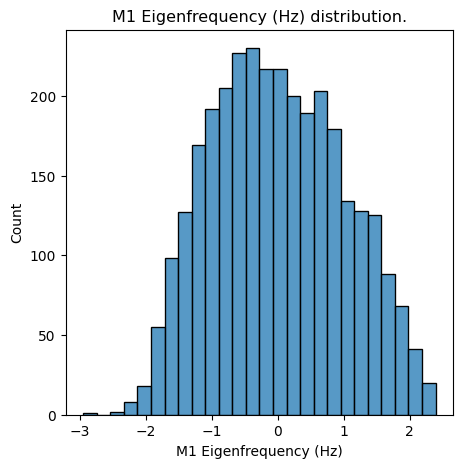

In [ ]:
from classic_ml import plot_distribution

plot_distribution(df=y_train, param_name='Eigenfrequency (Hz)',
                  log_scale=False, font_size=0.25, modes=[1])

## Формирование подвыборок

Определение подвыборок и даталоадеров:

In [ ]:
from dataset_preprocessing_torch import CustomDataset

trainset = CustomDataset(x_train, y_train)
valset = CustomDataset(x_val, y_val)
testset = CustomDataset(x_test, y_test)

batch_size = 256

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
print(len(train_loader))

13


# Forward модель (Fully Connected)

In [ ]:
num_pars_x = x_train.shape[1]
num_pars_y = y_train.shape[1]

class FCNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=num_pars_x, out_features=1000, bias=False),
            nn.BatchNorm1d(num_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=200, bias=False),
            nn.BatchNorm1d(num_features=200),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=num_pars_y, bias=True),
        )

    def forward(self, x):
        out = self.network(x)
        return out

    # Инициализация весов (НЕ ИСПОЛЬЗУЕТСЯ)
    def init(self):
        relu_gain = torch.nn.init.calculate_gain('relu')
        for child in self.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.kaiming_normal_(child.weight)

                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.kaiming_uniform_(child.weight)

                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()

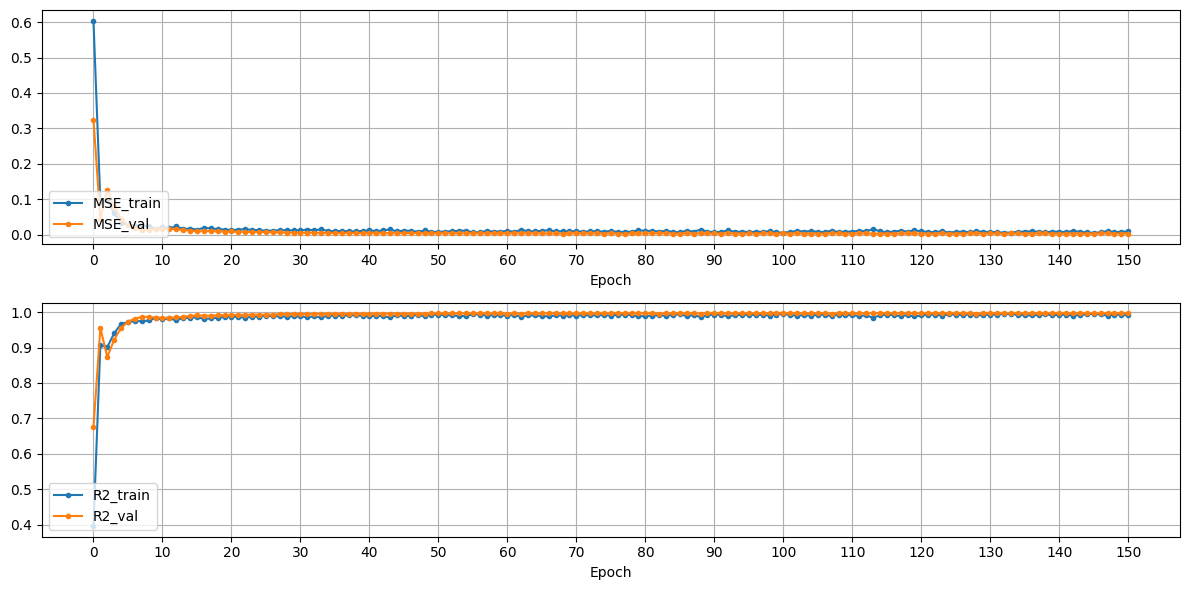

In [ ]:
from neural_ml import train_mlp

param_names_y = list(y_train.columns)
plot_param = 'M1 Eigenfrequency (Hz)'
num_epochs = 150

model_mlp = FCNetwork().to(device)
optimizer = Lion(model_mlp.parameters(), lr=1e-4)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', threshold=1e-8, verbose=True)
pp_mlp = train_mlp(model_mlp, train_loader, val_loader,
                   criterion, optimizer, scheduler,
                   num_epochs, param_names_y, plot_param)

Проверка на тестовом датасете:

In [ ]:
from neural_ml import get_readable_metrics_mlp

print(get_readable_metrics_mlp(model=model_mlp, data_loader=test_loader, param_names=param_names_y))

{'M1 Eigenfrequency (Hz)': [0.0034952969290316105, 0.996417760848999], 'M1 Quality factor': [0.2405131757259369, 0.6732804775238037], 'M1 Effective mass (kg)': [0.01417886558920145, 0.9837244749069214], 'M1 Noise (kg^2/s^3)': [0.5940411686897278, -0.03230738639831543], 'M1 TED (W)': [0.1211811751127243, 0.8791239857673645]}


Оценка времени работы нейросетевой модели:

In [ ]:
from neural_ml import get_elapsed_time_mlp

print(get_elapsed_time_mlp(model=model_mlp, data_loader=train_loader, num_samples=200))

0.0011589527130126953


# Inverse модель

### Сборка обычной inverse-модели:

In [ ]:
class InverseFC(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=num_pars_y, out_features=200, bias=False),
            nn.BatchNorm1d(num_features=200),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=1000, bias=False),
            nn.BatchNorm1d(num_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=num_pars_x, bias=True),
        )

    def forward(self, x):
        out = self.network(x)
        return out

    # Инициализация весов (НЕ ИСПОЛЬЗУЕТСЯ)
    def init(self):
        relu_gain = torch.nn.init.calculate_gain('relu')
        for child in self.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.kaiming_normal_(child.weight)

                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.kaiming_uniform_(child.weight)

                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()

### Обучение обычного тандема:

Обратите внимание: если вы выберете `plot_param` из X-данных, то пойдет отрисовка графиков обучения именно по этому параметру. К тому же, шедуллер будет корректировать `lr` согласно MSE-ошибке на этом самом параметре.

Также, стоит отметить, что если вы выберете `plot_param` из X-данных, то вы будете отслеживать MSE и R2 на выходе из `model_inverse` (это, простым языком, "стык" двух моделей), а если `plot_param` $\in$ Y-данным, то будете отслеживать MSE и R2 на выходе `model_forward`.

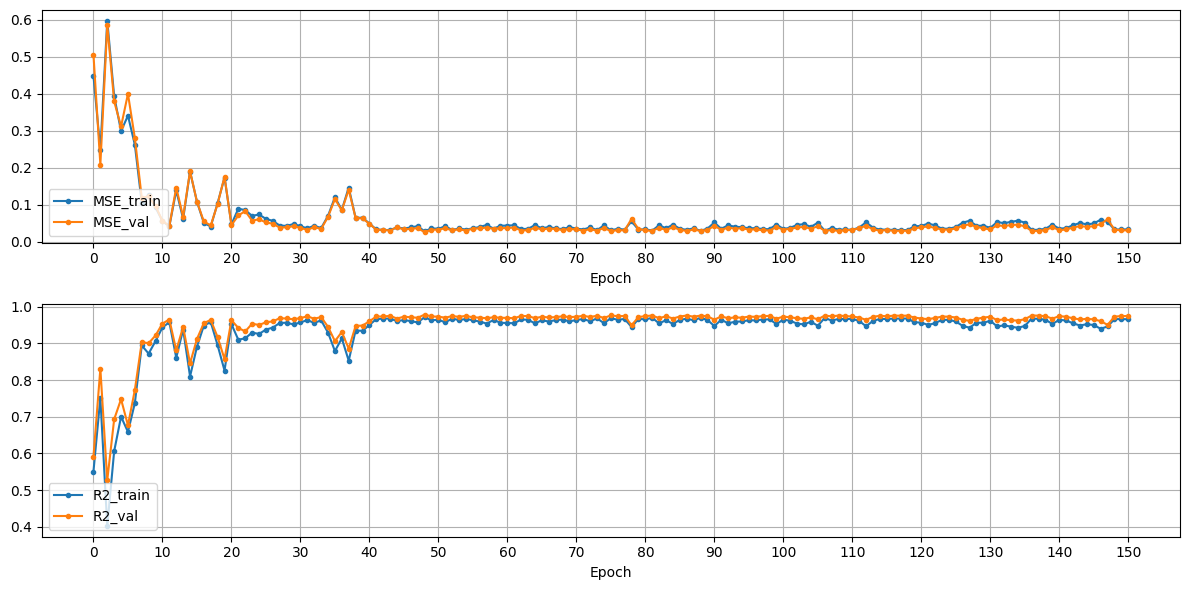

In [ ]:
from neural_ml import train_tandem

model_inverse = InverseFC().to(device)
model_forward = deepcopy(model_mlp).to(device)
optimizer = Lion(model_inverse.parameters(), lr=1e-4)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', threshold=1e-8, verbose=True)

num_epochs = 150
pp = train_tandem(model_inverse, model_forward,
                  train_loader, val_loader,
                  criterion, optimizer, scheduler,
                  num_epochs, param_names_x=None, param_names_y=param_names_y,
                  plot_param='M1 Quality factor')

Метрики на тестовой выборке (по X- и Y-данным):

In [ ]:
from neural_ml import get_readable_metrics_tandem

param_names_x = ['Beam length (um)', 'Beam width (nm)',
                 'Thickness_1 (nm)', 'Thickness_2 (nm)',
                 'Temperature (K)', 'Distance (nm)',
                 'Gate voltage (V)', 'Pretension (Pa)']

output_dict_inverse, output_dict_forward = get_readable_metrics_tandem(model_inverse, model_forward,
                                                                       test_loader,
                                                                       param_names_x, param_names_y)

print(output_dict_inverse)
print(output_dict_forward)

{'Beam length (um)': [0.07954062521457672, 0.9182397127151489], 'Beam width (nm)': [0.615714967250824, 0.3404344320297241], 'Thickness_1 (nm)': [2.5584356784820557, -1.5922973155975342], 'Thickness_2 (nm)': [2.077296733856201, -1.053417682647705], 'Temperature (K)': [0.7412593960762024, 0.2495863437652588], 'Distance (nm)': [2.1474359035491943, -1.246664047241211], 'Gate voltage (V)': [4.192992210388184, -3.2065391540527344], 'Pretension (Pa)': [1.3615206480026245, -0.4041404724121094]}
{'M1 Eigenfrequency (Hz)': [0.011970906518399715, 0.987731397151947], 'M1 Quality factor': [0.02791803516447544, 0.962075412273407], 'M1 Effective mass (kg)': [0.02160511165857315, 0.9752001166343689], 'M1 Noise (kg^2/s^3)': [0.021571865305304527, 0.9625130295753479], 'M1 TED (W)': [0.01603826880455017, 0.9840021133422852]}


Наблюдаем, что хоть метрики по Y-данным получаются неплохие, метрики по X-данным получаются весьма печальными. Это свидетельствует о том, что, хоть проблема неоднозначности определения X в безусловном тандеме и решается, однако получаемые значения могут не совпадать с истинными значениями X. Другими словами, `Inverse Network` находит однозначное решение X, но оно не совпадает с истинными значениями X.

### Сборка условной inverse-модели:

In [ ]:
class CondInverseFC(nn.Module):
    def __init__(self, fix_indices):
        super().__init__()
        self.fix_indices = fix_indices

        num_nonfix_params = num_pars_x - len(self.fix_indices)

        self.network_var = nn.Sequential(
            nn.Linear(in_features=num_pars_y, out_features=1000, bias=False),
            nn.BatchNorm1d(num_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=400, bias=False),
            nn.BatchNorm1d(num_features=400),
            nn.ReLU(),
        )

        self.network_fix = nn.Sequential(
            nn.Linear(in_features=len(self.fix_indices), out_features=400, bias=False),
            nn.BatchNorm1d(num_features=400),
            nn.ReLU(),
        )

        self.network_end = nn.Sequential(
            nn.Linear(in_features=800, out_features=200, bias=False),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=num_nonfix_params, bias=True)
        )


    def forward(self, y, x_fix):
        y = self.network_var(y)
        x_fix = self.network_fix(x_fix)
        y = torch.cat((y, x_fix), dim=1)
        out = self.network_end(y)

        return out

    def init(self):
        relu_gain = torch.nn.init.calculate_gain('relu')
        for child in self.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.kaiming_normal_(child.weight)

                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.kaiming_uniform_(child.weight)

                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()

##### 1

In [ ]:
from neural_ml import calculate_val_metrics_tandem_cond, ProgressPlotter

def train_tandem_cond_f(model_inverse_cond, model_forward,
                      fix_params,
                      train_loader, val_loader,
                      criterion, optimizer, scheduler,
                      num_epochs=100, param_names_x=None, param_names_y=None,
                      plot_param='M1 Eigenfrequency (Hz)'):
    """
    Trains conditional inverse model in tandem network.

    Sometimes when solving the reverse problem (find input by output) it is required to have some of the input parameters to be fixed. These are called conditional ones.

    Parameters
    ----------
    model_inverse_cond : model object
        Inverse tandem model that, in addition to convenient Y-data input, has some inputs fixed (e.g. temperature, distance, voltage and pretension).
    model_forward : model object
        Forward tandem model.
    fix_params : list of str
        List that contains param names which are to be fixed.
    train_loader : torch.utils.data.DataLoader
        Train dataset dataloader.
    val_loader : torch.utils.data.DataLoader
        Validation dataset dataloader.
    criterion : loss function object
    optimizer : optimizer object
    scheduler : scheduler object
    num_epochs : int
        Number of training epochs (default 100).
    param_names_x : list of str or None
        X-parameter names (format `Parameter`) to be used for metrics calculations. If None, uses 8 convenient params (default None).
    param_names_y : list of str or None
        Y-parameter names (format `M{mode} Param_name`) to be used for metrics calculations. If None, uses 5 convenient params and 4 modes (default None).
    plot_param : str
        Parameter name for which MSE and R2 metrics will be plotted (default 'M1 Eigenfrequency (Hz)').

    Returns
    ----------
    pp : ProgressPlotter object
        Class object that contains history dict for the specified `plot_param`.
    """
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    if param_names_x is not None:
        num_pars_x = len(param_names_x)
    else:
        param_names_x = ['Beam length (um)', 'Beam width (nm)',
                         'Thickness_1 (nm)', 'Thickness_2 (nm)',
                         'Temperature (K)', 'Distance (nm)',
                         'Gate voltage (V)', 'Pretension (Pa)']
        num_pars_x = len(param_names_x)

    if param_names_y is not None:
        num_pars_y = len(param_names_y)
    else:
        num_pars_y = 20

    fix_indices = get_fix_indices(param_names_x, fix_params)

    # Getting non-fixed indices
    nonfix_indices = [index for index in range(0, num_pars_x) if index not in fix_indices]

    pp = ProgressPlotter()

    model_forward.eval()

    for epoch in range(num_epochs+1):

        model_inverse_cond.train()

        for batch in train_loader:  # Training inverse model
            x, y = batch
            x, y = x.to(device), y.to(device)

            # Fixed x-parameters
            x_fix = x[:, fix_indices]

            # Non-fixed x-parameters (they're required to calculate loss below)
            x_nonfix_true = x[:, nonfix_indices]
            optimizer.zero_grad()

            # Obtaining predictions of inverse model
            output_inverse = model_inverse_cond(y, x_fix)

            # In output_inverse we have only non-fixed x-parameters --> we need to replace them in `x` in order to input `x` into the forward model
            x[:, nonfix_indices] = output_inverse

            output_forward = model_forward(x)

            loss = criterion(output_forward, y)  # calculating loss
            loss += criterion(output_inverse, x_nonfix_true)
            loss.backward()
            optimizer.step()

        # Calculating MSE and R2 metrics on train and val loaders
        with torch.no_grad():
            output_dict_train_inverse, output_dict_train_forward = calculate_val_metrics_tandem_cond(model_inverse_cond,
                                                                                                     model_forward,
                                                                                                     train_loader,
                                                                                                     fix_indices,
                                                                                                     param_names_x,
                                                                                                     param_names_y)
            output_dict_val_inverse, output_dict_val_forward = calculate_val_metrics_tandem_cond(model_inverse_cond,
                                                                                                 model_forward,
                                                                                                 val_loader,
                                                                                                 fix_indices,
                                                                                                 param_names_x,
                                                                                                 param_names_y)

        # Scheduler step
        if plot_param in param_names_x:
            scheduler.step(output_dict_val_inverse[plot_param][0])
        elif plot_param in param_names_y:
            scheduler.step(output_dict_val_forward[plot_param][0])

        # Logging
        if plot_param in param_names_x:
            pp.add_scalar('MSE_train', output_dict_train_inverse[plot_param][0].cpu().detach().numpy())
            pp.add_scalar('R2_train', output_dict_train_inverse[plot_param][1].cpu().detach().numpy())
            pp.add_scalar('MSE_val', output_dict_val_inverse[plot_param][0].cpu().detach().numpy())
            pp.add_scalar('R2_val', output_dict_val_inverse[plot_param][1].cpu().detach().numpy())

        elif plot_param in param_names_y:
            pp.add_scalar('MSE_train', output_dict_train_forward[plot_param][0].cpu().detach().numpy())
            pp.add_scalar('R2_train', output_dict_train_forward[plot_param][1].cpu().detach().numpy())
            pp.add_scalar('MSE_val', output_dict_val_forward[plot_param][0].cpu().detach().numpy())
            pp.add_scalar('R2_val', output_dict_val_forward[plot_param][1].cpu().detach().numpy())

        # Displaying current results
        if epoch % 10 == 0:
            pp.display([['MSE_train', 'MSE_val'], ['R2_train', 'R2_val']])
    return pp

### Обучение условного тандема:

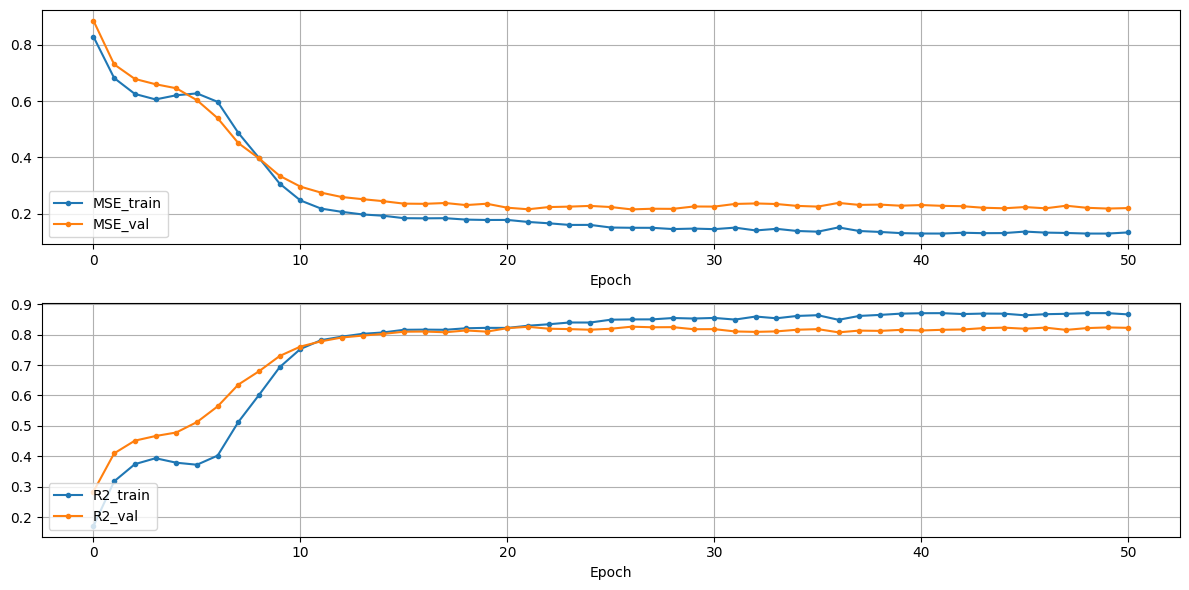

In [ ]:
from neural_ml import train_tandem_cond
from neural_ml import get_fix_indices

# X-parameter names:
param_names_x = ['Beam length (um)', 'Beam width (nm)',
                 'Thickness_1 (nm)', 'Thickness_2 (nm)',
                 'Temperature (K)', 'Distance (nm)',
                 'Gate voltage (V)', 'Pretension (Pa)']

# Parameters to be fixed:
fix_params = ['Temperature (K)', 'Distance (nm)',
                 'Gate voltage (V)', 'Pretension (Pa)']

# Function that returns indices of fixed parameters in overall X-parameters list
fix_indices = get_fix_indices(param_names_x, fix_params)
nonfix_indices = [index for index in range(0, len(param_names_x)) if index not in fix_indices]

# Creating new inverse model
model_inverse_cond = CondInverseFC(fix_indices).to(device)

# Making a copy of pretrained forward MLP model
model_forward = deepcopy(model_mlp).to(device)

# Optimizer, criterion and scheduler (see info about scheduler reference parameter above)
optimizer = Lion(model_inverse_cond.parameters(), lr=1e-5)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', threshold=1e-8, verbose=True)

# Training process
num_epochs = 50
pp = train_tandem_cond_f(model_inverse_cond, model_forward,
                       fix_params,
                       train_loader, val_loader,
                       criterion, optimizer, scheduler,
                       num_epochs, param_names_x=None, param_names_y=param_names_y,
                       plot_param='M1 Quality factor')

Метрики на тестовой выборке (по X- и Y-данным):

In [ ]:
from neural_ml import get_readable_metrics_tandem_cond

param_names_x = ['Beam length (um)', 'Beam width (nm)',
                 'Thickness_1 (nm)', 'Thickness_2 (nm)',
                 'Temperature (K)', 'Distance (nm)',
                 'Gate voltage (V)', 'Pretension (Pa)']

output_dict_inverse, output_dict_forward = get_readable_metrics_tandem_cond(model_inverse_cond, model_forward,
                                                                            test_loader, fix_indices,
                                                                            param_names_x, param_names_y)

print(output_dict_inverse)
print(output_dict_forward)

{'Beam length (um)': [0.022455353289842606, 0.9769179821014404], 'Beam width (nm)': [0.15216338634490967, 0.8369996547698975], 'Thickness_1 (nm)': [0.8275597095489502, 0.16148734092712402], 'Thickness_2 (nm)': [0.9331640601158142, 0.07756286859512329], 'Temperature (K)': [0.0, 1.0], 'Distance (nm)': [0.0, 1.0], 'Gate voltage (V)': [0.0, 1.0], 'Pretension (Pa)': [0.0, 1.0]}
{'M1 Eigenfrequency (Hz)': [0.030020590871572495, 0.9692328572273254], 'M1 Quality factor': [0.20994354784488678, 0.7148070931434631], 'M1 Effective mass (kg)': [0.023653211072087288, 0.9728491306304932], 'M1 Noise (kg^2/s^3)': [0.18492525815963745, 0.6786422729492188], 'M1 TED (W)': [0.04739982634782791, 0.952719509601593]}


# Тестирование

**Тест "безусловного" тандема**

In [ ]:
param_list = [2.166e6]
y_real = pd.DataFrame([param_list])
y_real.columns = y_train.columns
print(y_real)

y_real = s.transform_real_y(y_real)
print(y_real)
y_real_torch = torch.tensor(y_real.iloc[:, :].values, dtype=torch.float32).to(device)

# Подаем реальные данные на вход инверсной модели
with torch.no_grad():
    x_real_pred = model_inverse(y_real_torch)
x_real_pred = pd.DataFrame(x_real_pred.detach().cpu().numpy())
print(x_real_pred)

x_real_pred, y_real = s.reverse_transform(x_real_pred, y_real, concat_required=False)
x_real_pred = pd.DataFrame(x_real_pred)
x_real_pred.columns = x_train.columns

real_pred = pd.concat([x_real_pred, y_real], axis=1)
real_pred.head()

**Тест условного тандема**

Вставьте желаемое значение резонансной частоты:

In [ ]:
# Value of desired resonant frequency
param_list = [2.166e6]  # <-- YOUR INPUT HERE

# Casting to pd.DataFrame
y = pd.DataFrame([param_list])
y.columns = y_train.columns

# Performing custom scaling
y = s.transform_real_y(y)

# Casting to torch tensor
y_torch = torch.tensor(y.values, dtype=torch.float32).to(device)

Впишите желаемые значения входных параметров:

In [ ]:
# ENTER DESIRED PARAMS BELOW
w = 200  # input desired beam width here, nm
t_1 = 100  # beam layer 1 thickness, nm
t_2 = 30  # beam layer 2 thickness, nm
temperature = 1  # temperature, K
gate_distance = 600  # distance from the nanobeam to the control gate, nm
gate_voltage = 0  # voltage on control gate, V
pretension = 0  # nanobeam pretension, Pa

# The first two values in `x` aren't used.
# They're required in order to perform scaling (scaler works only with 8 params together)
x = pd.DataFrame([[1, # <-- these values are NOT fixed and they take arbitrary values
                   w, t_1, t_2,
                   temperature, gate_distance, gate_voltage,
                   pretension]])
x.columns = x_train.columns
x = s.transform_real_x(x)
x = torch.tensor(x.values, dtype=torch.float32).to(device)

Смотрим на предсказания модели и сравниваем с реальными физичными данными из эксперимента:

In [ ]:
# Lets give the real data to the trained model
with torch.no_grad():
    x_pred_unfix = model_inverse_cond(y_torch, x[:, fix_indices]) # obtained only non-fixed params
x_pred = x
x_pred[:, nonfix_indices] = x_pred_unfix # replace arbitrary values with predicted ones
x_pred = pd.DataFrame(x_pred.detach().cpu().numpy())

x_pred, y = s.reverse_transform(x_pred, y, concat_required=False)
x_pred = pd.DataFrame(x_pred)
x_pred.columns = x_train.columns

prediction = pd.concat([x_pred, y], axis=1)
prediction.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz)
0,80.389954,200.0,100.0,30.0,1.0,600.0,8.514876e-07,14.848544,2166000.0


В реальном эксперименте такой резонансной частоте соответствует длина нанопровода $L = 70$ мкм.